# Example occupancy analysis

Consider the same SSU example described in the {doc}`getting_started` tutorial. Now let's do a little more involved analysis. Let's assume that a renovation project is planned which will temporarily take 50 out of the 110 SSU beds out of service. The mitigation plan is to identify a subset of patient types served by the SSU that can be routed to an alternate holding area. We can use hillmaker to evaluate different subsets of patients to move with respect to the reduced capacity of the SSU during the renovation.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools

import pandas as pd
import hillmaker as hm

In [3]:
ssu_stopdata = './data/ssu_2024.csv'
stops_df = pd.read_csv(ssu_stopdata, parse_dates=['InRoomTS','OutRoomTS'])
stops_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59877 entries, 0 to 59876
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   PatID      59877 non-null  int64         
 1   InRoomTS   59877 non-null  datetime64[ns]
 2   OutRoomTS  59877 non-null  datetime64[ns]
 3   PatType    59877 non-null  object        
 4   LOS_hours  59877 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(1), object(1)
memory usage: 2.3+ MB


What are all the patient types?

In [4]:
patient_types = stops_df['PatType'].unique()
patient_types

array(['IVT', 'MYE', 'CAT', 'ART', 'OTH'], dtype=object)

Let's start by running a scenario that includes all of the patient types.

In [5]:
ssu_all = hm.Scenario(scenario_name='ssu_all',
                      data=stops_df,
                      in_field='InRoomTS',
                      out_field='OutRoomTS',
                      start_analysis_dt='2024-01-02',
                      end_analysis_dt='2024-09-30',
                      cat_field='PatType',
                      bin_size_minutes=60,
                      cap=110,
                      verbosity=1,
                     )

In [6]:
ssu_all.make_hills()

2023-10-31 11:13:43,959 - hillmaker.hills - INFO - Starting scenario ssu_all
2023-10-31 11:13:53,087 - hillmaker.summarize - INFO - Created nonstationary summaries - ['PatType']
2023-10-31 11:13:54,238 - hillmaker.summarize - INFO - Created nonstationary summaries - []
2023-10-31 11:13:54,280 - hillmaker.summarize - INFO - Created stationary summaries - ['PatType']
2023-10-31 11:13:54,316 - hillmaker.summarize - INFO - Created stationary summaries - []
2023-10-31 11:13:55,654 - hillmaker.hills - INFO - bydatetime and summaries by datetime created (seconds): 11.6798
2023-10-31 11:13:56,250 - hillmaker.plotting - INFO - Full week plots created (seconds): 0.5956
2023-10-31 11:13:56,251 - hillmaker.hills - INFO - Total time (seconds): 12.2772


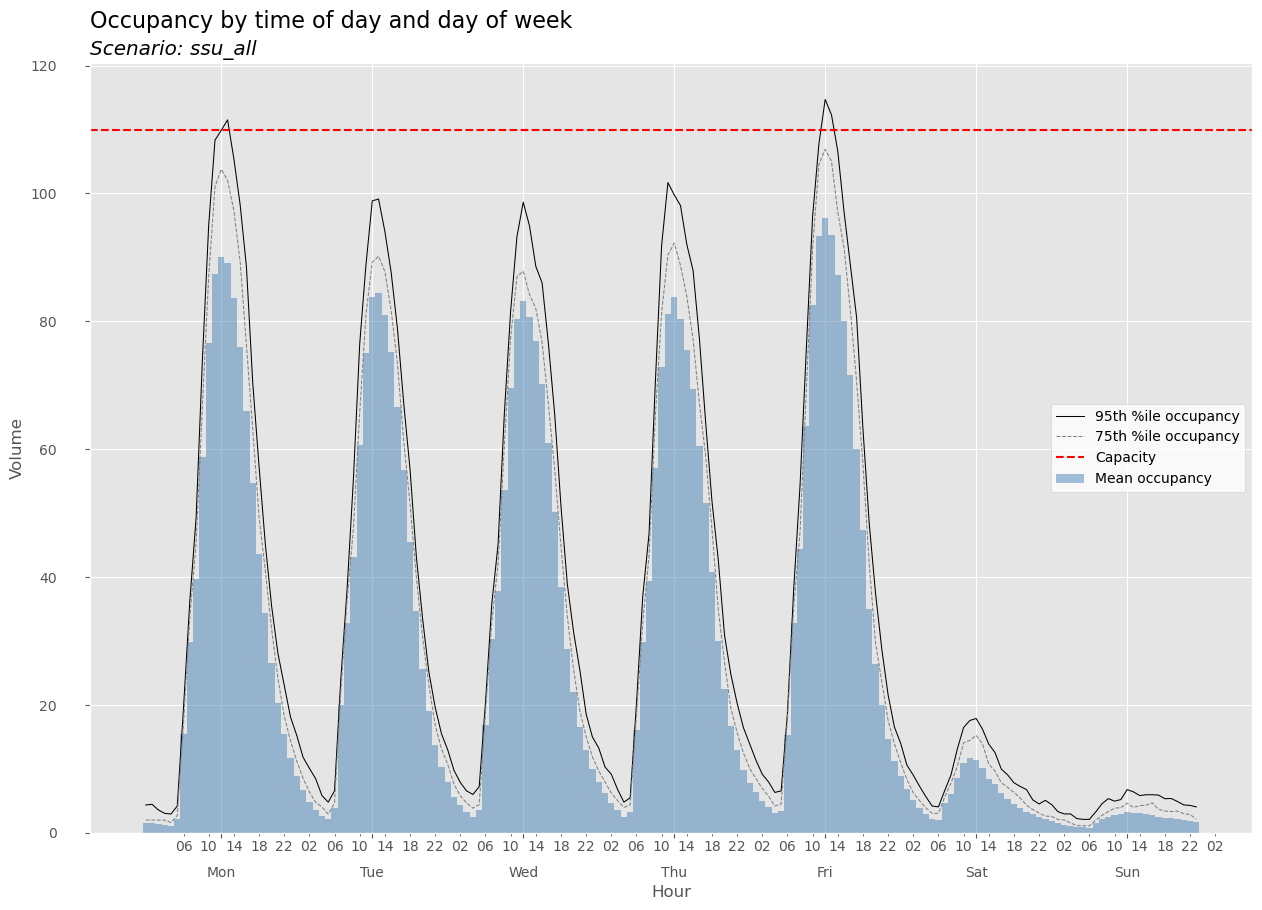

In [7]:
ssu_all.get_plot()

Ok, now we need to temporarily close 50 beds. Which patient populations can we move out of the SSU temporarily in order to deal with the reduced capacity? Of course we want to try to use the remaining capacity of 60 SSU beds as efficiently as possible.

One simple thing we could do is to run hillmaker with different combinations of patient types excluded from the analyis and then look at the resulting plots to see if a few scenarios stand out as reasonable alternatives. The `cats_to_exclude` parameters is useful for this type of analysis.

We can use the itertools library to generate combinations of patient types to consider rerouting. Each combination constitutes a different scenario. We will try combinations of up to three patient types. for example, we can generate a list of all combinations of two patient types like this:

In [8]:
[_ for _ in itertools.combinations(patient_types, 2)]

[('IVT', 'MYE'),
 ('IVT', 'CAT'),
 ('IVT', 'ART'),
 ('IVT', 'OTH'),
 ('MYE', 'CAT'),
 ('MYE', 'ART'),
 ('MYE', 'OTH'),
 ('CAT', 'ART'),
 ('CAT', 'OTH'),
 ('ART', 'OTH')]

At a high level, our analysis plan is:

1. Create a dictionary of hillmaker inputs that are fixed across all the scenarios.
2. Iterate over all the potential combinations of patients to be rerouted.
    - create a new hillmaker scenario based on the current iteration's patient type combination
    - run hillmaker
    - create weekly occupancy plot for this scenario
3. Review all of the occupancy plots to eliminate obviously bad scenarios
4. Decide among the candidate scenarios based on the hillmaker results as well as other non-capacity related consideratoins.

## Step 1 - Fixed inputs

In [9]:
# Create dict of fixed inputs
ssu_inputs = {'data': stops_df,
              'in_field': 'InRoomTS',
              'out_field': 'OutRoomTS',
              'start_analysis_dt': '2024-01-02',
              'end_analysis_dt': '2024-09-30',
              'cat_field': 'PatType',
              'bin_size_minutes': 60,
              'cap': 60,
             }

## Step 2 - Process each scenario with hillmaker

In [10]:
# Generate the list of combinations of patient types to exclude
patient_types = stops_df['PatType'].unique()
exclusions = [[_ for _ in itertools.combinations(patient_types, i)] for i in range(1,4)]

# Create container dictionary to store the weekly plots
plots = {}

# Main loop over number of patient types to exclude
for num_cats_excluded in range(1, 4):
    # Loop over each combination of patient types excluded (the -1 is for the zero index)
    for exclusion in exclusions[num_cats_excluded - 1]:
        cats_to_exclude = exclusion
        print(f'cats_to_exclude = {cats_to_exclude}')
        scenario_name = f'no_{"_".join(list(exclusion))}'
        print(f'scenario_name = {scenario_name}')
        
        # Create scenario object
        scenario = hm.create_scenario(params_dict=ssu_inputs, 
                                      scenario_name=scenario_name, cats_to_exclude=cats_to_exclude)
        # Make the hills
        scenario.make_hills()
        
        # Create the weekly plot (they're also being exported)
        plots[scenario_name] = scenario.make_weekly_plot(ylabel='Patients', plot_export_path='./output')
    

cats_to_exclude = ('IVT',)
scenario_name = no_IVT
cats_to_exclude = ('MYE',)
scenario_name = no_MYE
cats_to_exclude = ('CAT',)
scenario_name = no_CAT
cats_to_exclude = ('ART',)
scenario_name = no_ART
cats_to_exclude = ('OTH',)
scenario_name = no_OTH
cats_to_exclude = ('IVT', 'MYE')
scenario_name = no_IVT_MYE
cats_to_exclude = ('IVT', 'CAT')
scenario_name = no_IVT_CAT
cats_to_exclude = ('IVT', 'ART')
scenario_name = no_IVT_ART
cats_to_exclude = ('IVT', 'OTH')
scenario_name = no_IVT_OTH
cats_to_exclude = ('MYE', 'CAT')
scenario_name = no_MYE_CAT
cats_to_exclude = ('MYE', 'ART')
scenario_name = no_MYE_ART
cats_to_exclude = ('MYE', 'OTH')
scenario_name = no_MYE_OTH
cats_to_exclude = ('CAT', 'ART')
scenario_name = no_CAT_ART
cats_to_exclude = ('CAT', 'OTH')
scenario_name = no_CAT_OTH
cats_to_exclude = ('ART', 'OTH')
scenario_name = no_ART_OTH
cats_to_exclude = ('IVT', 'MYE', 'CAT')
scenario_name = no_IVT_MYE_CAT
cats_to_exclude = ('IVT', 'MYE', 'ART')
scenario_name = no_IVT_MYE_ART
cats_to_

## Step 3 - Review weekly plots for promising scenarios

By reviewing the weekly occupancy plots, we can identify a handful of promising scenarios.

For example, excluding just the CAT patients clearly doesn't free up enough capacity.

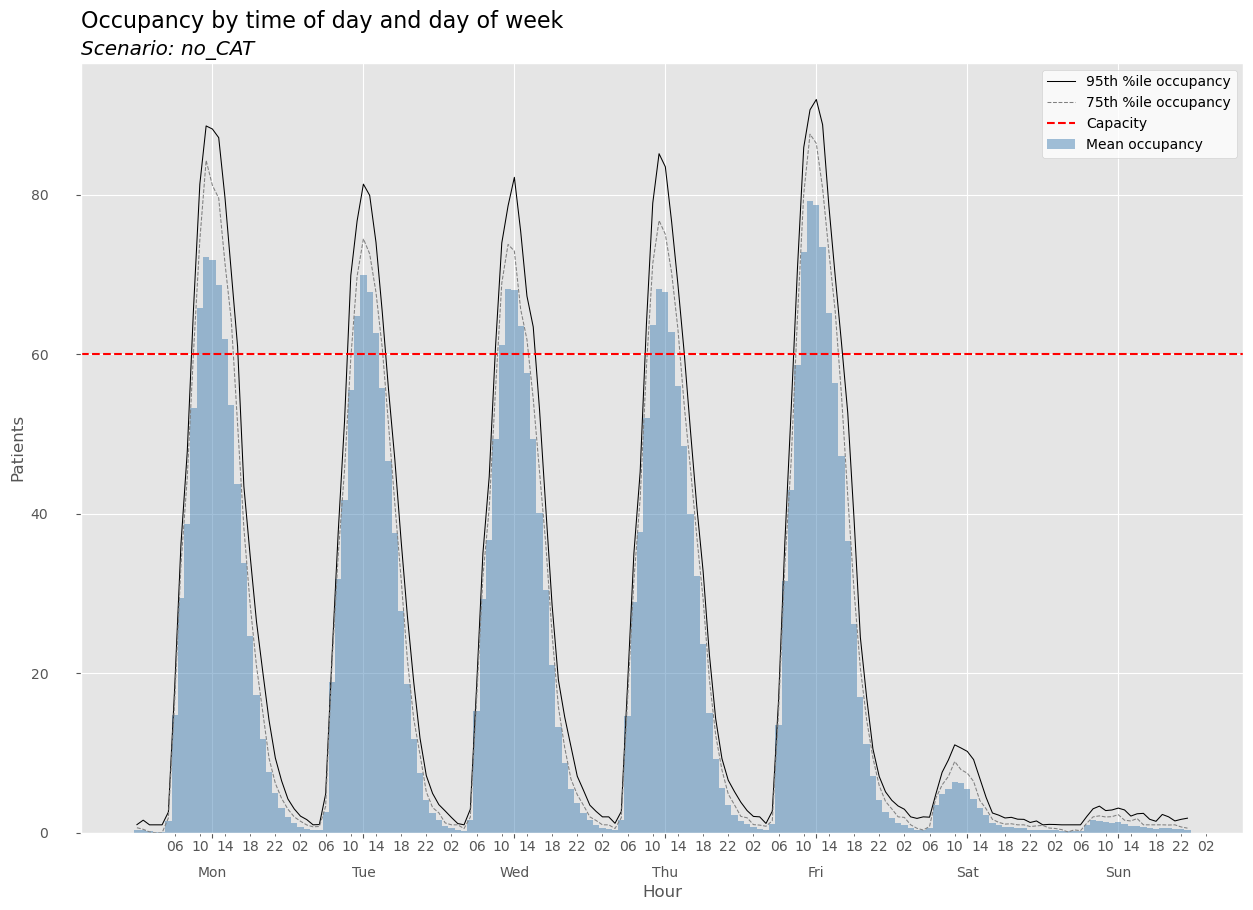

In [11]:
plots['no_CAT']

Conversely, excluding IVT, ART, and OTH, results in too much unused capacity.

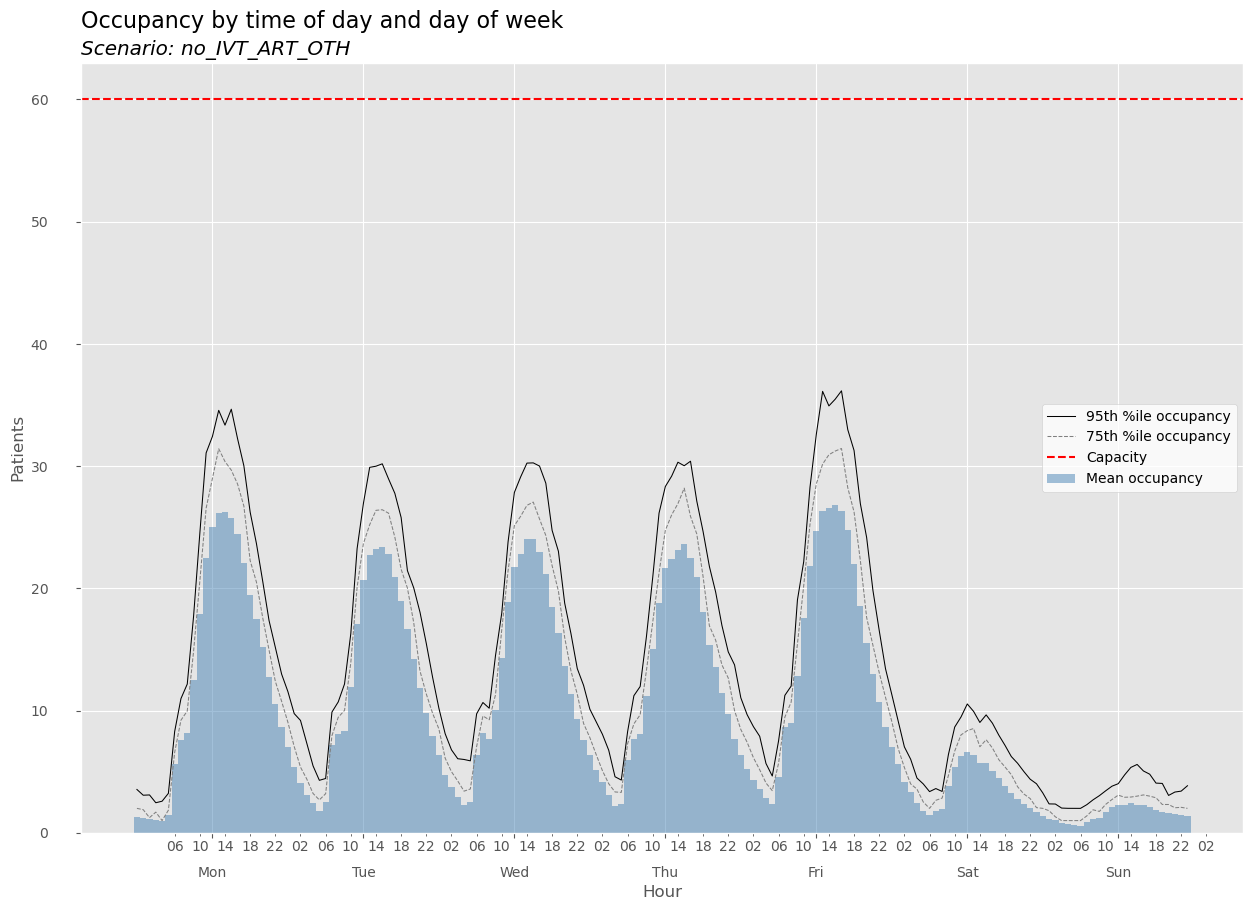

In [12]:
plots['no_IVT_ART_OTH']

The two most promising scenarios would seem to be:

- CAT, ART, OTH
- IVT, MYE

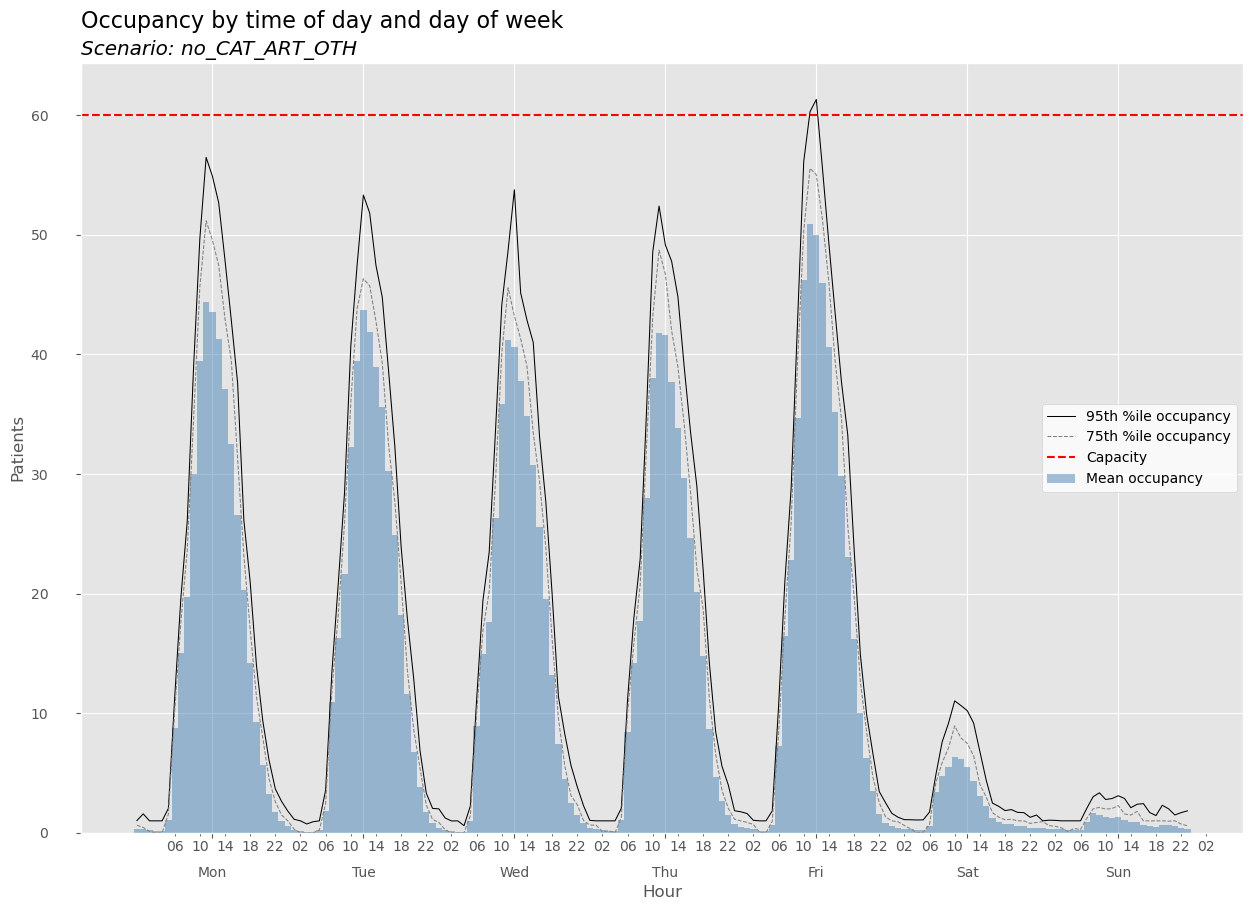

In [13]:
plots['no_CAT_ART_OTH']

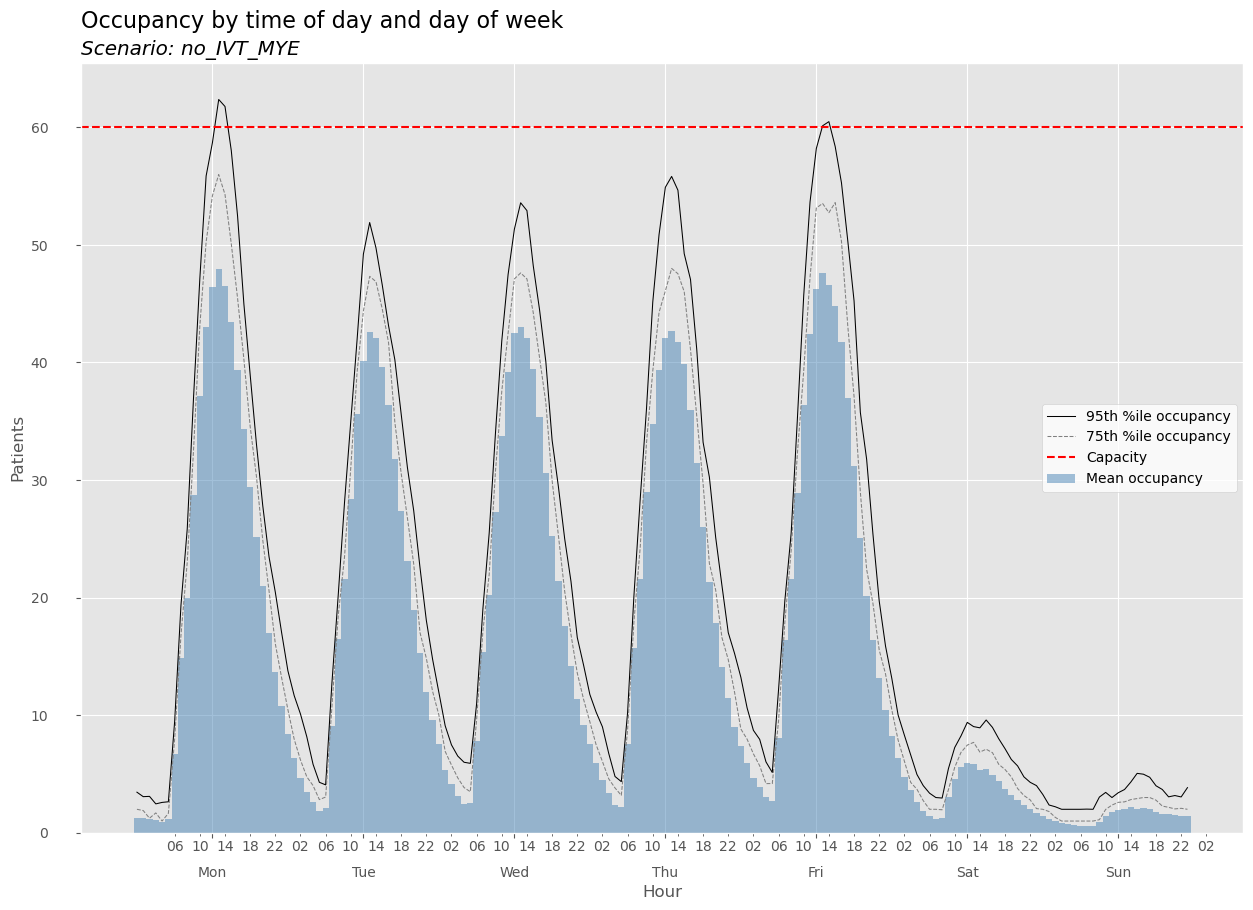

In [14]:
plots['no_IVT_MYE']

Of course, this is just a starting point for actually making a decision. There are other factors that will influence the feasibility of these (or other) scenarios. For example, a scenario involving moving only the IVT patients leads to this projected occupancy. Perhaps with some changes in scheduling such as moving some volume from Mondays and Fridays to mid-week, this scenario might be workable.

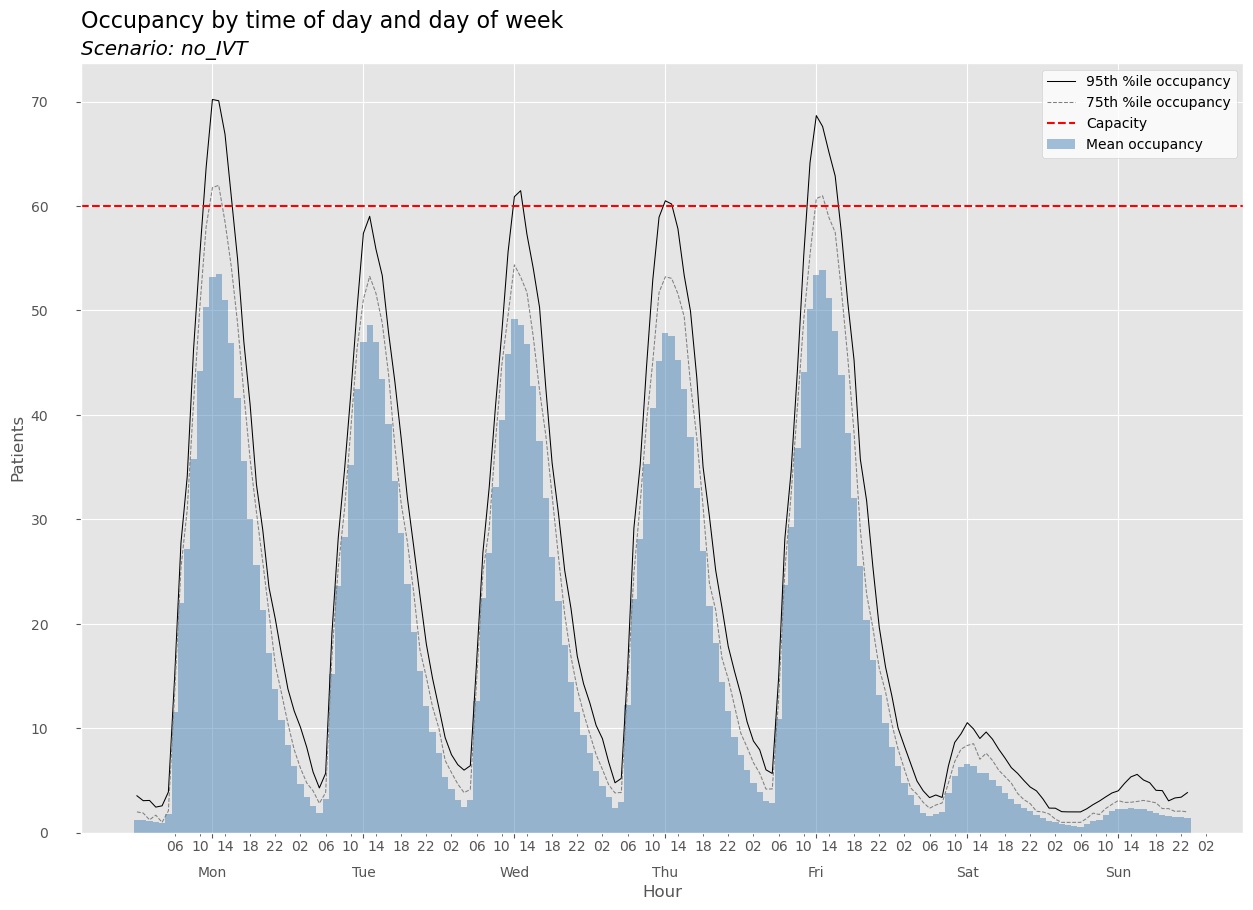

In [15]:
plots['no_IVT']